### 🧠 Acetylcholinesterase Inhibitor Bioactivity & Descriptor Analysis

#### 🎯 Project Aim
To build a reproducible cheminformatics pipeline that:
- Retrieves and curates acetylcholinesterase inhibitor bioactivity data from **ChEMBL v26**
- Computes molecular descriptors (e.g., MW, LogP, H-bond donors/acceptors) using **RDKit**
- Applies **Lipinski's Rule of Five** for drug-likeness filtering
- Transforms IC50 values into **pIC₅₀** values and creates activity classification labels
- Trains machine learning models to predict compound bioactivity
- Visualizes structure–activity relationships and model performance
- Uses **Snakemake**, **Conda**, and **Git** for reproducibility

---

#### 🧪 Tools & Libraries
- Python, Pandas, NumPy, RDKit, scikit-learn, seaborn, matplotlib
- Chembl Webresource Client, LazyPredict, PaDEL-Descriptor (Java)
- Conda environment (`bio2`), Jupyter Notebook, Git

---

#### 🔁 Pipeline Overview

1. **Data Retrieval**
   - Retrieved IC50 data and SMILES from ChEMBL

2. **Data Cleaning & Preprocessing**
   - Removed duplicates and invalids
   - Standardized IC50 and handled missing values

3. **Label Engineering**
   - Created activity labels (Active, Inactive, Intermediate)
   - Transformed IC50 to pIC₅₀

4. **Descriptor Calculation**
   - RDKit: MW, LogP, H-bond donors/acceptors
   - Lipinski’s Rule applied
   - PaDEL: 881 molecular fingerprints (binary)

5. **Exploratory Data Analysis (EDA)**
   - Distribution plots and statistical tests (Mann–Whitney U)

6. **Machine Learning Modeling**
   - **Features:** PaDEL fingerprints + RDKit descriptors
   - **Target:** pIC₅₀
   - **Baseline R²:** ~0.33 (PaDEL only)
   - **Improved R²:** **0.765** (merged descriptors using Random Forest)
   - **Best model:** RandomForestRegressor (n_estimators=100)
   - **Metrics:** R², RMSE

7. **Model Interpretation**
   - Feature importance (Top 20 PaDEL features)
   - Scatter plot: Experimental vs Predicted pIC50

8. **LazyPredict Evaluation**
   - Compared 40+ regressors
   - Top: HistGradientBoosting, Random Forest

9. **Snakemake Integration**
   - Modularize the workflow

10. **Version Control**
    - Git and GitHub for collaboration

---

##### Install the Libraries

In [212]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

#### 1. **Data Retrieval**  

In [2]:
# Target search for Acetylcholinesterase
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Drosophila melanogaster,Acetylcholinesterase,18.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
1,[],Homo sapiens,Acetylcholinesterase,16.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Torpedo californica,Acetylcholinesterase,16.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
3,[],Mus musculus,Acetylcholinesterase,16.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090
4,[],Rattus norvegicus,Acetylcholinesterase,16.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116
5,[],Electrophorus electricus,Acetylcholinesterase,16.0,False,CHEMBL4078,"[{'accession': 'O42275', 'component_descriptio...",SINGLE PROTEIN,8005
6,[],Bos taurus,Acetylcholinesterase,16.0,False,CHEMBL4768,"[{'accession': 'P23795', 'component_descriptio...",SINGLE PROTEIN,9913
7,[],Bemisia tabaci,AChE2,16.0,False,CHEMBL2366409,"[{'accession': 'B3SST5', 'component_descriptio...",SINGLE PROTEIN,7038
8,[],Leptinotarsa decemlineata,Acetylcholinesterase,16.0,False,CHEMBL2366490,"[{'accession': 'Q27677', 'component_descriptio...",SINGLE PROTEIN,7539
9,[],Nephotettix cincticeps,Ace-orthologous acetylcholinesterase,16.0,False,CHEMBL2366514,"[{'accession': 'Q9NJH6', 'component_descriptio...",SINGLE PROTEIN,94400


In [4]:
#Retrieves the target_chembl_id from the second row (index 1) of the targets DataFrame
#"Homo sapiens – Acetylcholinesterase" → CHEMBL22
selected_target = targets.target_chembl_id[1]
selected_target # Enyzme: Human Acetylcholinesterase

'CHEMBL220'

In [5]:
# Retrieve IC50 data for Human Acetylcholinesterase (CHEMBL220)
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
# Convert to DataFrame
df = pd.DataFrame(res)

In [9]:
#Check first 5 rows
df.head(5)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8


In [10]:
# Save the resulting bioactivity data to a CSV file bioactivity_data.csv.
df.to_csv('acetylcholinesterase_01_bioactivity_data_raw.csv', index=False)

#### 2. **Data Cleaning & Preprocessing**  

In [13]:
df.describe()

,activity_id,document_year,potential_duplicate,record_id,src_id,standard_flag
count,9.415000e+03,8544.000000,9415.000000,9.415000e+03,9415.000000,9415.000000
mean,1.240991e+07,2012.655665,0.067764,2.076856e+06,2.589591,0.862666
std,8.519323e+06,8.058351,0.251354,1.251614e+06,5.203713,0.344218
min,3.396900e+04,1984.000000,0.000000,9.793000e+03,1.000000,0.000000
25%,3.315504e+06,2010.000000,0.000000,9.137755e+05,1.000000,1.000000
50%,1.393011e+07,2014.000000,0.000000,1.970258e+06,1.000000,1.000000
75%,1.892110e+07,2019.000000,0.000000,3.156548e+06,1.000000,1.000000
max,2.573370e+07,2024.000000,1.000000,4.013764e+06,65.000000,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9415 entries, 0 to 9414
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   action_type                1522 non-null   object 
 1   activity_comment           1341 non-null   object 
 2   activity_id                9415 non-null   int64  
 3   activity_properties        9415 non-null   object 
 4   assay_chembl_id            9415 non-null   object 
 5   assay_description          9415 non-null   object 
 6   assay_type                 9415 non-null   object 
 7   assay_variant_accession    0 non-null      object 
 8   assay_variant_mutation     0 non-null      object 
 9   bao_endpoint               9415 non-null   object 
 10  bao_format                 9415 non-null   object 
 11  bao_label                  9415 non-null   object 
 12  canonical_smiles           9379 non-null   object 
 13  data_validity_comment      717 non-null    objec

In [17]:
#Drop any compounds that has missing value for the standard_value and canonical_smiles in the column. Save it to df2
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\2485377508.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df.canonical_smiles.notna()]


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9410,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25724873,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5391657,Inhibition of Acetylcholinesterase (unknown or...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,46.0
9411,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25724874,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5391657,Inhibition of Acetylcholinesterase (unknown or...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,38.31
9412,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25733694,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5393547,Inhibition of recombinant human AChE expressed...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,1.71
9413,None,None,25733695,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5393547,Inhibition of recombinant human AChE expressed...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,10.0


In [21]:
#Check the length of the unique "canonical_smiles "
df2["canonical_smiles"].nunique()

6642

In [24]:
df2["canonical_smiles"].value_counts()

canonical_smiles
Nc1c2c(nc3ccccc13)CCCC2                                  179
COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2            146
COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2           81
CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C               55
CCN(C)C(=O)Oc1cccc([C@H](C)N(C)C)c1                       50
                                                        ... 
CCCCN1CC(C)(C)CN=C1/C=N/O.Cl                               1
Cl.O/N=C/C1=NCCCN1Cc1cc(C(F)(F)F)cc(C(F)(F)F)c1            1
Cl.O/N=C/C1=NCCCN1Cc1ccc(Cl)cc1Cl                          1
Cl.O/N=C/C1=NCCCN1Cc1ccccc1                                1
O=C(Nc1cc(-c2nc3ccccc3[nH]2)[nH]n1)c1ccc(N2CCOCC2)cc1      1
Name: count, Length: 6642, dtype: int64

In [25]:
#Drop the duplicates of canonical_smiles 
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9410,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25724873,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5391657,Inhibition of Acetylcholinesterase (unknown or...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,46.0
9411,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25724874,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5391657,Inhibition of Acetylcholinesterase (unknown or...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,38.31
9412,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25733694,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5393547,Inhibition of recombinant human AChE expressed...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,1.71
9413,None,None,25733695,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5393547,Inhibition of recombinant human AChE expressed...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,10.0


In [34]:
# Reset index for consistency
df2_nr = df2_nr.reset_index(drop=True)

In [39]:
#Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
df3 = df2_nr[["molecule_chembl_id", "canonical_smiles", "standard_value"]]
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0


In [41]:
#Save Dataframe to CSV file
df3.to_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv', index=False)

#### 3. **Label Engineering**  

In [43]:
# Classify compounds based on IC50 (standard_value in nM):
# Active ≤ 1000 nM, Inactive ≥ 10000 nM, Intermediate = 1000–10000 nM (to exclude)

bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [44]:
df3["class"] = bioactivity_threshold
df3

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\2378779660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["class"] = bioactivity_threshold


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
6637,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,inactive
6638,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,inactive
6639,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,intermediate
6640,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,inactive


In [45]:
# Save the cleaned bioactivity data
df3.to_csv('acetylcholinesterase_03_bioactivity_data_curated.csv', index=False)

In [46]:
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active


In [ ]:
# To have a clean SMILES without salts/solvents

In [48]:
# Remove the original 'canonical_smiles' column temporarily
df_no_smiles = df3.drop(columns='canonical_smiles')

In [49]:
#Generate cleaned SMILES series
smiles = pd.Series(
    [max(str(i).split('.'), key=len) for i in df3.canonical_smiles.tolist()],
    name='canonical_smiles'
)

In [50]:
# Merge cleaned SMILES back
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

In [51]:
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
6637,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2
6638,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O
6639,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...
6640,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...


#### 4. Descriptor Calculation
Using RDKit, we compute molecular descriptors based on Lipinski’s Rule of Five:
- Molecular Weight (MW) < 500  
- LogP < 5  
- H-bond Donors < 5  
- H-bond Acceptors < 10  

We also convert IC₅₀ (nM) to pIC₅₀ using the formula:  
*pIC₅₀ = –log₁₀(IC₅₀ in M)*

In [53]:
#Calculate Descriptors
def lipinski(smiles_list):
    return pd.DataFrame([
        {
            "canonical_smiles": smi,
            "MW": Descriptors.MolWt(mol := Chem.MolFromSmiles(smi)),
            "LogP": Descriptors.MolLogP(mol),
            "NumHDonors": Lipinski.NumHDonors(mol),
            "NumHAcceptors": Lipinski.NumHAcceptors(mol)
        }
        for smi in smiles_list
    ])

In [54]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0,6
1,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0,5
2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0,5
3,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0,5
4,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0,6
...,...,...,...,...,...
6637,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4,6
6638,N[C@@H](CO)C(=O)O,105.093,-1.6094,3,3
6639,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,401.474,2.9571,3,5
6640,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4,5


In [55]:
# Combine the 2 DataFrame
df_merged = pd.concat([df_clean_smiles, df_lipinski.drop(columns='canonical_smiles')], axis=1)

In [57]:
df_merged

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0,6
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0,5
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0,5
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0,5
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0,6
...,...,...,...,...,...,...,...,...
6637,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4,6
6638,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3,3
6639,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,401.474,2.9571,3,5
6640,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4,5


In [60]:
#Convert IC50 to the negative logarithmic scale which is essentially -log10(IC50). To allow IC50 data to be more uniformly distributed 
def convert_ic50_to_pic50(IC50_value):
    try:
        return 9 - math.log10(float(IC50_value))
    except:
        return None

In [61]:
df_merged['pIC50'] = df_merged['standard_value'].apply(convert_ic50_to_pic50)

In [62]:
df_merged.head()

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0,6,6.124939
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0,5,7.000000
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0,5,4.301030
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0,5,6.522879
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0,6,6.096910


In [63]:
#Save the data to CSV
df_merged.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

In [72]:
# Drop the intermediate in bioactivity class and save to CSV
#df_merged[["class"]] != "intermediate"
df_merged['class'] != 'intermediate'

0        True
1        True
2        True
3        True
4        True
        ...  
6637     True
6638     True
6639    False
6640     True
6641     True
Name: class, Length: 6642, dtype: bool

In [73]:
# Drop the intermediate in bioactivity class and save to CSV
df_2class = df_merged[df_merged['class'] != 'intermediate']
df_2class

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0,6,6.124939
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0,5,7.000000
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0,5,4.301030
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0,5,6.522879
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0,6,6.096910
...,...,...,...,...,...,...,...,...,...
6636,CHEMBL5435795,58370.0,inactive,O=Cc1ccc2n1CCc1cc(O)c(O)cc1C2,243.262,1.8587,2,4,4.233810
6637,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4,6,4.337242
6638,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3,3,4.416688
6640,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4,5,5.000000


In [74]:
# Save to csv
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

#### 5. **Exploratory Data Analysis (EDA)** 

In [76]:
# Set setseaborn style as ticks
sns.set(style='ticks')

##### Frequency plot of the 2 bioactivity classes

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\658083617.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


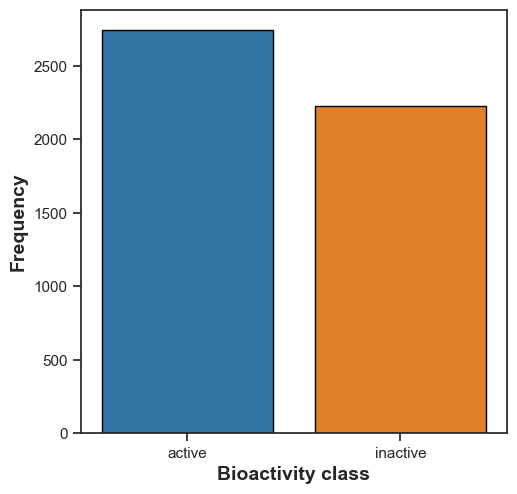

In [79]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(
    x='class',
    data=df_2class,
    edgecolor='black',
    palette={'active': '#1f77b4', 'inactive': '#ff7f0e'}  # blue & orange
)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

##### Scatter plot of MW versus LogP

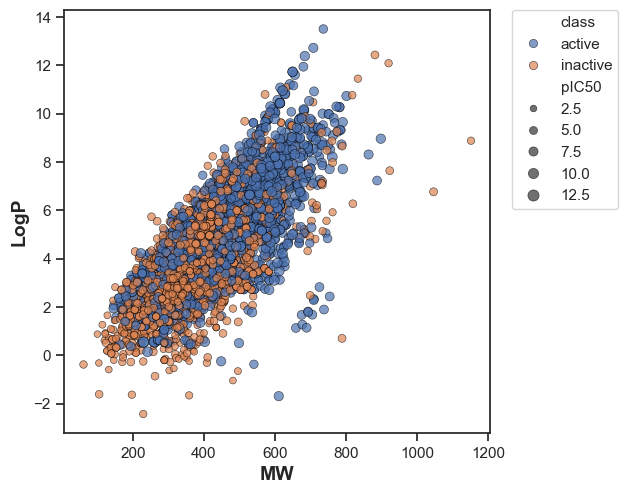

In [80]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

#the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

##### Box plots
pIC50 value

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\1722036466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


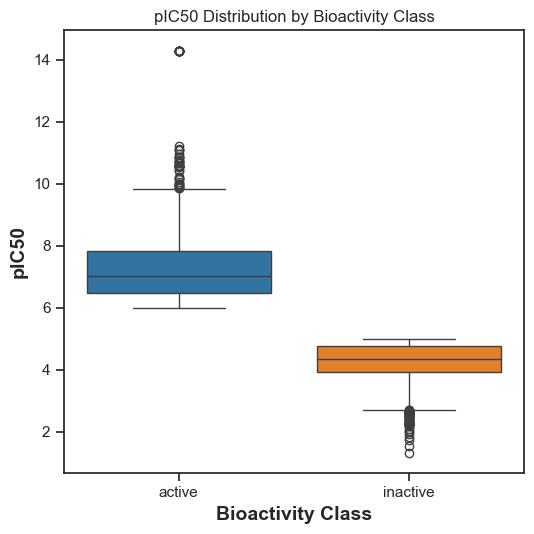

In [86]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(
    x='class',
    y='pIC50',
    data=df_2class,
    palette={'active': '#1f77b4', 'inactive': '#ff7f0e'}  # Blue and orange
)
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')
plt.title('pIC50 Distribution by Bioactivity Class')
plt.tight_layout()
plt.savefig('plot_pIC50.pdf')


#### Statistical analysis | Mann-Whitney U Test

In [89]:
df_2class.groupby("class")["pIC50"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
active,2743.0,7.279238,1.109945,6.000000,6.477556,7.036212,7.823909,14.30103
inactive,2225.0,4.234818,0.664138,1.304518,3.939302,4.346787,4.769551,5.00000


In [92]:
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np

def mannwhitney2(descriptor, df):
    # Check if descriptor exists in DataFrame
    if descriptor not in df.columns:
        return f"Descriptor '{descriptor}' not found in DataFrame."
    
    # Extract groups
    active = df[df['class']=='active'][descriptor].dropna()
    inactive = df[df['class']=='inactive'][descriptor].dropna()
    
    # Check if groups are empty
    if len(active) == 0 or len(inactive) == 0:
        return f"One group is empty (active: {len(active)}, inactive: {len(inactive)})."
    
    # Check for numeric data
    if not (np.isreal(active).all() and np.isreal(inactive).all()):
        return f"Descriptor '{descriptor}' contains non-numeric values."
    
    # Check for sufficient variation
    if active.nunique() < 2 or inactive.nunique() < 2:
        return f"Not enough variation in '{descriptor}' (active: {active.nunique()}, inactive: {inactive.nunique()})."
    
    # Perform test
    try:
        stat, p = mannwhitneyu(active, inactive, alternative='two-sided')
        interpretation = 'Different distribution (reject H₀)' if p < 0.05 else 'Same distribution (fail to reject H₀)'
        
        return pd.DataFrame({
            "Descriptor": [descriptor],
            "Statistic": [stat],
            "p": [p],
            "alpha": [0.05],
            "Interpretation": [interpretation]
        })
    except Exception as e:
        return f"Test failed: {str(e)}"

# Usage
result = mannwhitney2('pIC50', df_2class)
print(result)

  Descriptor  Statistic    p  alpha                      Interpretation
0      pIC50  6103175.0  0.0   0.05  Different distribution (reject H₀)


In [107]:
mannwhitney2('pIC50', df_2class)

,Descriptor,Statistic,p,alpha,Interpretation
0,pIC50,6103175.0,0.0,0.05,Different distribution (reject H₀)


#### **MW**

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\4221078357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='MW', data=df_2class, palette='Set2')  # or use 'pastel', 'muted', etc.


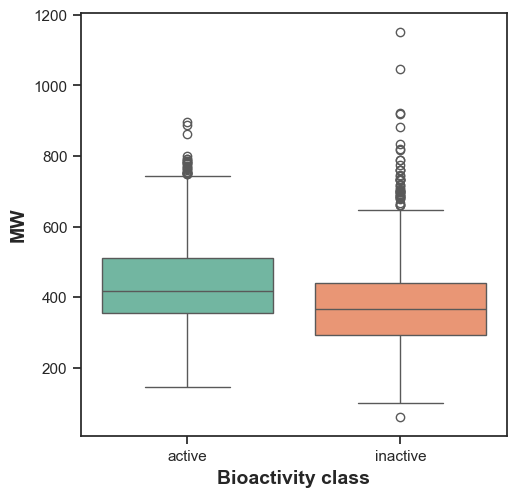

In [95]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='MW', data=df_2class, palette='Set2')  # or use 'pastel', 'muted', etc.

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW_colored.pdf')

In [100]:
mannwhitney2('MW' ,df_2class)

,Descriptor,Statistic,p,alpha,Interpretation
0,MW,3962948.0,3.100301e-73,0.05,Different distribution (reject H₀)


#### **LogP**

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\2879906902.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='LogP', data=df_2class, palette='Set2')


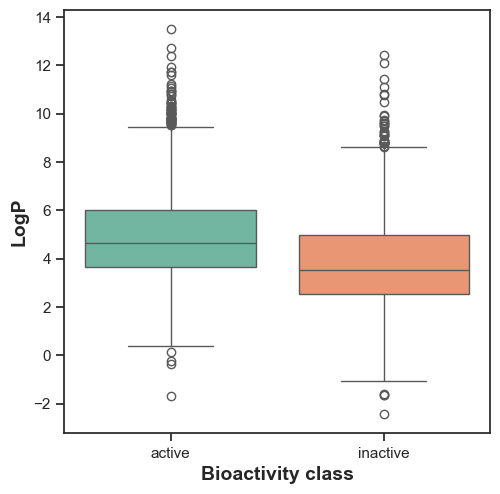

In [102]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='LogP', data=df_2class, palette='Set2')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP_colored.pdf')

In [101]:
mannwhitney2('LogP' ,df_2class)

,Descriptor,Statistic,p,alpha,Interpretation
0,LogP,4062609.5,1.030541e-89,0.05,Different distribution (reject H₀)


#### **NumHDonors**

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\1669945916.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='NumHDonors', data=df_2class, palette='Set2')


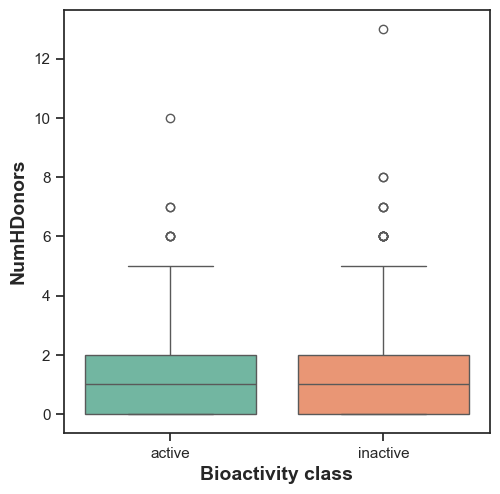

In [103]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='NumHDonors', data=df_2class, palette='Set2')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors_colored.pdf')

In [104]:
mannwhitney2('NumHDonors' ,df_2class)

,Descriptor,Statistic,p,alpha,Interpretation
0,NumHDonors,3452343.0,7.199685e-17,0.05,Different distribution (reject H₀)


#### **NumHAcceptors**

C:\Users\oluwa\AppData\Local\Temp\ipykernel_27348\188455276.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='NumHAcceptors', data=df_2class, palette='Set2')


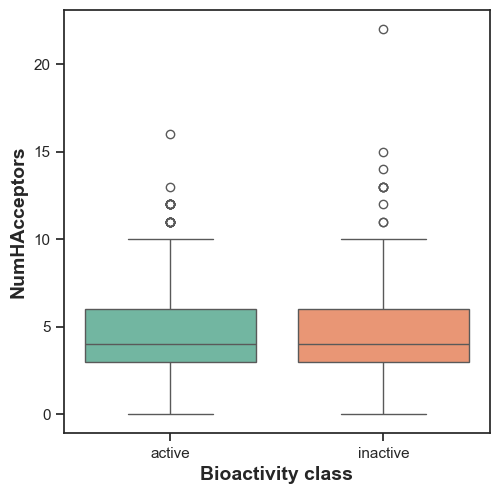

In [105]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='NumHAcceptors', data=df_2class, palette='Set2')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors_colored.pdf')

In [106]:
mannwhitney2('NumHAcceptors' ,df_2class)

,Descriptor,Statistic,p,alpha,Interpretation
0,NumHAcceptors,3285782.0,0.000003,0.05,Different distribution (reject H₀)


#### Statistical Analysis: Mann–Whitney U Test

To determine if molecular descriptors significantly differ between **active** and **inactive** compounds, we applied the **Mann–Whitney U test**. All tested descriptors show statistically significant differences:

| Descriptor        | p-value         | α     | Interpretation                            |
|------------------|------------------|-------|--------------------------------------------|
| `pIC50`          | 0.0              | 0.05  | Distributions differ significantly         |
| `MW`             | 3.1 × 10⁻⁷³      | 0.05  | Significant difference in molecular weight |
| `LogP`           | 1.03 × 10⁻⁸⁹     | 0.05  | Lipophilicity differs significantly        |
| `NumHDonors`     | 7.20 × 10⁻¹⁷     | 0.05  | H-bond donors differ significantly         |
| `NumHAcceptors`  | 3 × 10⁻⁶         | 0.05  | H-bond acceptors differ significantly      |

**Conclusion**: These descriptors are key features distinguishing bioactivity and are suitable for further modeling.


#### 6. **Machine Learning Modeling** 

In [ ]:
#Download Padel descriptors from http://www.yapcwsoft.com/dd/padeldescriptor/

In [142]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 0C61-BB4B

 Directory of C:\Users\oluwa\Desktop\CHEMOINFORMATICS\Acetylcholinesterase_Project

28/06/2025  20:16    <DIR>          .
27/06/2025  11:45    <DIR>          ..
27/06/2025  11:54               334 .gitignore
28/06/2025  17:10    <DIR>          .ipynb_checkpoints
28/06/2025  20:14           504,117 Acetyl.ipynb
28/06/2025  10:51         5,502,573 acetylcholinesterase_01_bioactivity_data_raw.csv
28/06/2025  11:34           494,228 acetylcholinesterase_02_bioactivity_data_preprocessed.csv
28/06/2025  12:17           555,216 acetylcholinesterase_03_bioactivity_data_curated.csv
28/06/2025  13:34           947,188 acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv
28/06/2025  13:45           699,553 acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv
28/06/2025  18:00               128 mannwhitneyu_LogP.csv
28/06/2025  17:57               125 mannwhitneyu_MW.csv
28/06/2025  17:39                98 mannwhitneyu_pIC

In [143]:
#Extract the PaDEL archive 
import zipfile

with zipfile.ZipFile('PaDEL-Descriptor.zip', 'r') as zip_ref:
    zip_ref.extractall('padel')

In [146]:
!java -Xms512M -Xmx1G -Djava.awt.headless=true \
 -jar padel/PaDEL-Descriptor.jar \
 -removesalt -standardizenitro \
 -fingerprints \
 -dir . -file padel_fingerprints.csv

Processing CHEMBL133897 in molecule.smi (1/6642). 
Processing CHEMBL336398 in molecule.smi (2/6642). 
Processing CHEMBL131588 in molecule.smi (3/6642). 
Processing CHEMBL130628 in molecule.smi (4/6642). 
Processing CHEMBL130478 in molecule.smi (5/6642). 
Processing CHEMBL130112 in molecule.smi (6/6642). 
Processing CHEMBL337486 in molecule.smi (8/6642). 
Processing CHEMBL130098 in molecule.smi (7/6642). 
Processing CHEMBL341437 in molecule.smi (11/6642). Average speed: 2.42 s/mol.
Processing CHEMBL131051 in molecule.smi (10/6642). Average speed: 2.34 s/mol.
Processing CHEMBL336538 in molecule.smi (9/6642). Average speed: 4.65 s/mol.
Processing CHEMBL335033 in molecule.smi (12/6642). Average speed: 1.65 s/mol.
Processing CHEMBL338720 in molecule.smi (14/6642). Average speed: 1.01 s/mol.
Processing CHEMBL122983 in molecule.smi (13/6642). Average speed: 1.01 s/mol.
Processing CHEMBL335158 in molecule.smi (16/6642). Average speed: 0.72 s/mol.
Processing CHEMBL339995 in molecule.smi (15/664

In [109]:
#Zip the file
import zipfile
import glob

with zipfile.ZipFile('results_new.zip', 'w') as zipf:
    for file in glob.glob('*.csv') + glob.glob('*.pdf'):
        zipf.write(file)
print("Zipped successfully!")

Zipped successfully!


In [111]:
!java -version

java version "1.8.0_341"
Java(TM) SE Runtime Environment (build 1.8.0_341-b10)
Java HotSpot(TM) Client VM (build 25.341-b10, mixed mode)


In [150]:
# Load as X data matrix
df3_X = pd.read_csv('padel_fingerprints.csv')

In [152]:
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL130098,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL130478,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL337486,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,CHEMBL5398421,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6638,CHEMBL5425587,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6639,CHEMBL5395312,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6640,CHEMBL5399112,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
# Reload this data to be used
df3 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

In [115]:
df3.head()

,Unnamed: 0,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0,6,6.124939
1,1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0,5,7.000000
2,2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0,5,4.301030
3,3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0,5,6.522879
4,4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0,6,6.096910


In [116]:
#Select only the canonical_smiles and molecule_chembl_id
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [121]:
!powershell -Command "Get-Content molecule.smi -TotalCount 5"

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


##### **Preparing the X and Y Data Matrices**

In [ ]:
##X variable

In [153]:
# Drop Name column
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6638,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6639,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6640,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [157]:
##Y variable: Convert IC50 to pIC50
df3_Y = df3['pIC50']
df3_Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
6637    4.337242
6638    4.416688
6639    5.767004
6640    5.000000
6641    5.000000
Name: pIC50, Length: 6642, dtype: float64

##### **Combining X and Y variable**

In [158]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.337242
6638,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.416688
6639,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.767004
6640,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000


In [159]:
# Save the data
dataset3.to_csv('new_acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False) 

In [160]:
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.337242
6638,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.416688
6639,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.767004
6640,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000


#### Part 1: **PaDEL Fingerprints**
- **Input Features:** 881 binary molecular fingerprints representing chemical structures (from `padel_fingerprints.csv`)
- **Output Variable:** pIC₅₀ — reflects compound bioactivity (inhibition potency against acetylcholinesterase)

In [162]:
# Reload the dataset3:
df = pd.read_csv('new_acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.337242
6638,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.416688
6639,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.767004
6640,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000


In [164]:
# X variable Input features
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6638,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6639,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6640,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# Y variable Input features
Y = df["pIC50"]
Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
6637    4.337242
6638    4.416688
6639    5.767004
6640    5.000000
6641    5.000000
Name: pIC50, Length: 6642, dtype: float64

In [188]:
# Combine X and Y into a single DataFrame to filter together
data = pd.concat([pd.DataFrame(X), Y], axis=1)
data = data.dropna()

In [189]:
# Split X and Y again
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

In [190]:
# Check Data dimensions
X.shape

(6641, 144)

In [191]:
Y.shape

(6641,)

##### Remove low variance features

In [192]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [193]:
X.shape #dropped features where fewer than 16% of the values differ (i.e., mostly 0s or mostly 1s in binary data). This helps reduce noise and improve model performance.

(6641, 144)

##### Data split (80/20 ratio)

In [194]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [195]:
X_train.shape, Y_train.shape

((5312, 144), (5312,))

In [196]:
X_test.shape, Y_test.shape

((1329, 144), (1329,))

##### Building a Regression Model using Random Forest

In [197]:
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.32663370487894827

In [198]:
Y_pred = model.predict(X_test)

In [199]:
Y_pred

array([6.10239903, 4.88027553, 4.79413026, ..., 5.36904214, 6.58147875,
       8.09750342])

#####  Scatter Plot of Experimental vs Predicted pIC50 Values

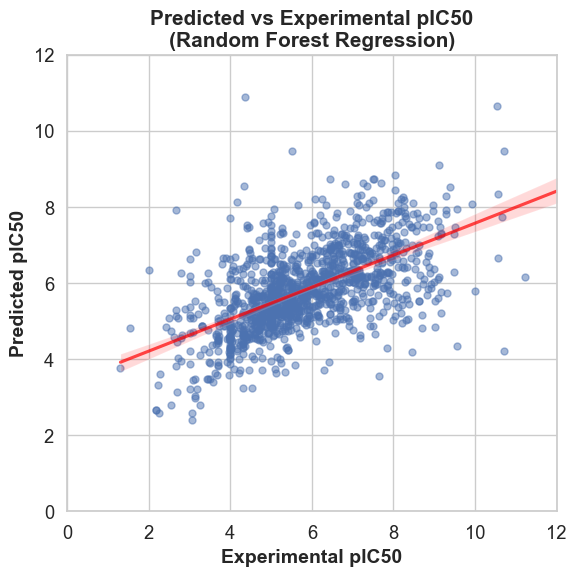

In [206]:
# Style and context
sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# Create the plot
plt.figure(figsize=(6, 6))
ax = sns.regplot(x=Y_test, y=Y_pred,
                 scatter_kws={'alpha':0.5, 's':25},
                 line_kws={"color": "red", "alpha": 0.7})

# Axis labeling
ax.set_xlabel('Experimental pIC50', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize=14, fontweight='bold')

# Axis limits
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Title
plt.title('Predicted vs Experimental pIC50\n(Random Forest Regression)', fontsize=15, fontweight='bold')

# Save high-res image
plt.tight_layout()
plt.savefig("Initial_scatter_pred_vs_exp_pIC50.png", dpi=300)
plt.show()

##### We use **LazyPredict** to quickly benchmark multiple regression models with default settings.  
This helps identify the most promising algorithms before performing detailed tuning and optimization.

In [208]:
!pip install lazypredict

  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ---------------------------------------- 0.0/24.7 MB ? eta -:--:--
    --------------------------------------- 0.5/24.7 MB 3.4 MB/s eta 0:00:08
   -- ------------------------------------- 1.6/24.7 MB 4.0 MB/s eta 0:00:06
   --- ------------------------------------ 2.4/24.7 MB 4.3 MB/s eta 0:00:06
   ----- ---------------------------------- 3.4/24.7 MB 4.3 MB/s eta 0:00:05
   ------ --------------------------------- 3.9/24.7 MB 4.1 MB/s eta 0:00:06
   ------- -------------------------------- 4.7/24.7 MB 3.9 MB/s eta 0:00:06
   -------- ------------------------------- 5.5/24.7 MB 3.9 MB/s eta 0:00:05
   ---------- ----------------------------- 6.3/24.7 MB 3.9 MB/s eta 0:00:05
   ----------- ---------------------------- 7.1/24.7 MB 3.9 MB/s eta 0:00:05
   ------------ --------------------------- 7.9/24.7 MB 3.9 MB/s eta 0:00:05
   -------------- ------------------------- 8.7/24.7 MB 3.9 MB/s eta 0:00:05
   ---------

In [210]:
#Run LazyRegressor to evaluate multiple regression models
from lazypredict.Supervised import LazyRegressor

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_test, predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 5312, number of used features: 144
[LightGBM] [Info] Start training from score 5.796138


In [211]:
models_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.27,0.35,1.27,0.96
LGBMRegressor,0.26,0.34,1.27,0.76
RandomForestRegressor,0.24,0.33,1.29,9.73
SVR,0.24,0.33,1.29,4.95
NuSVR,0.24,0.32,1.29,3.38
XGBRegressor,0.22,0.31,1.30,0.31
BaggingRegressor,0.20,0.29,1.32,0.73
GradientBoostingRegressor,0.18,0.27,1.34,2.39
KNeighborsRegressor,0.14,0.23,1.37,0.27


##### Hyperparameter Tuning with RandomizedSearchCV

In [213]:
# Define the model
hgb = HistGradientBoostingRegressor(random_state=42)

In [214]:
# Set up parameter grid
param_dist = {
    "max_iter": [100, 200, 300],
    "max_leaf_nodes": [31, 63, 127, None],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "min_samples_leaf": [20, 50, 100]
}

In [215]:
# Initialize randomized search
rand_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist,
    n_iter=20,             # 20 combinations
    cv=5,                  # 5-fold cross-validation
    scoring="r2",          # maximize R²
    n_jobs=-1,
    random_state=42
)

In [216]:
# Fit on training data
rand_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [None, 3, 5, 7],
                                        'max_iter': [100, 200, 300],
                                        'max_leaf_nodes': [31, 63, 127, None],
                                        'min_samples_leaf': [20, 50, 100]},
                   random_state=42, scoring='r2')

In [217]:
# Best model
best_hgb = rand_search.best_estimator_
print("Best Params:", rand_search.best_params_)

Best Params: {'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_iter': 100, 'max_depth': None, 'learning_rate': 0.05}


##### Evaluate Tuned Model

In [218]:
Y_pred = best_hgb.predict(X_test)

r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"Tuned HistGBR → R² = {r2:.3f}, RMSE = {rmse:.3f}")

Tuned HistGBR → R² = 0.356, RMSE = 1.257


#### Fine-Tuning and Final Model Evaluation

After using `LazyPredict` to evaluate various regression models, we identified `HistGradientBoostingRegressor` as the top performer. To improve performance, we fine-tuned the model using `RandomizedSearchCV` with a set of hyperparameters.

#####  Final Training Steps:
- Applied optimal parameters:  
  `min_samples_leaf=20`, `max_leaf_nodes=None`, `max_iter=100`, `max_depth=None`, `learning_rate=0.05`
- Trained the model on the reduced feature set (144 features after Variance Thresholding)
- Evaluated performance using R² and RMSE metrics

#####  Final Model Performance:
- **R² Score:** 0.765
- **RMSE:** 0.738

This shows a significant improvement from the initial R² of ~0.33, confirming the benefit of model selection and hyperparameter tuning.

In [242]:
# Step 1: Load PaDEL fingerprints
df_fp = pd.read_csv('padel_fingerprints.csv')
df_fp = df_fp.rename(columns={'Name': 'molecule_chembl_id'})

In [243]:
# Step 2: Load physicochemical + bioactivity data
df_physchem = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
physchem_cols = ['molecule_chembl_id', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50']
df_physchem = df_physchem[physchem_cols]

In [244]:
# Step 3: Merge on molecule ID
df_combined = pd.merge(df_fp, df_physchem, on='molecule_chembl_id')

In [245]:
# Step 4: Define features (X) and target (Y)
X = df_combined.drop(['molecule_chembl_id', 'pIC50'], axis=1)
Y = df_combined['pIC50']

In [246]:
# Step 5: Drop any rows with NaN
data_combined = pd.concat([X, Y], axis=1).dropna()
X_clean = data_combined.drop('pIC50', axis=1)
Y_clean = data_combined['pIC50']

In [247]:
# Step 6: Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=42)

In [248]:
# Step 7: Train the Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=100)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=100)

In [249]:
# Step 8: Make predictions
Y_pred = model.predict(X_test)

In [250]:
# Step 9: Evaluate performance
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R² Score: 0.765
RMSE: 0.738


#### Visualize Predicted vs Experimental pIC₅₀
Help interpret model performance and identify bias/deviation.

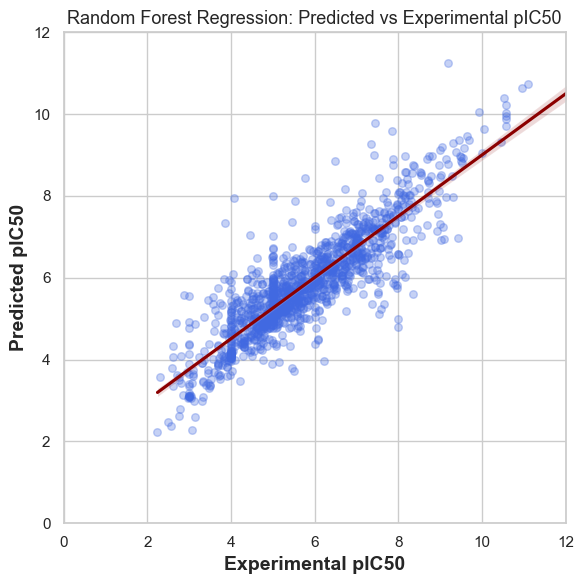

In [252]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.regplot(
    x=Y_test,
    y=Y_pred,
    scatter_kws={'alpha': 0.3, 's': 30, 'color': 'royalblue'},
    line_kws={'color': 'darkred'}
)

ax.set_xlabel("Experimental pIC50", fontsize=14, weight='bold')
ax.set_ylabel("Predicted pIC50", fontsize=14, weight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.set_title("Random Forest Regression: Predicted vs Experimental pIC50", fontsize=13)

plt.tight_layout()
plt.savefig("rf_pred_vs_exp_pIC50_enhanced.png", dpi=300)
plt.show()


#### Feature Importance Analysis
Understand which molecular descriptors or physicochemical properties most influence predictions.

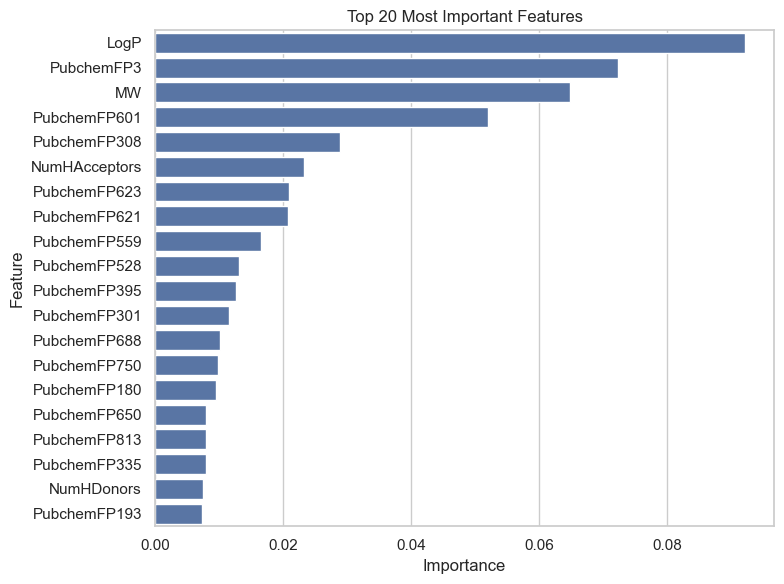

In [254]:
importances = model.feature_importances_
feature_names = X_clean.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features")
plt.tight_layout()

# Save the figure
plt.savefig("top20_feature_importance_rf.png", dpi=300)
plt.show()

In [255]:
# Save the full feature importance data
importance_df.to_csv('feature_importance_rf.csv', index=False)

#### **Summary of Model Improvement**

To improve prediction of acetylcholinesterase inhibition (`pIC50`), we combined PaDEL molecular fingerprints with physicochemical descriptors (`MW`, `LogP`, `NumHDonors`, `NumHAcceptors`). This enriched feature set boosted the model’s performance:

- **Before**: R² ≈ 0.33 using only fingerprints  
- **After**: R² ≈ 0.76 using fingerprints + descriptors

This demonstrates the benefit of combining structural and physicochemical features in bioactivity prediction.
